In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Данные о транзакциях суммарно по категориям "Выживание", "Социализация", "Самореализация" (SSSR)

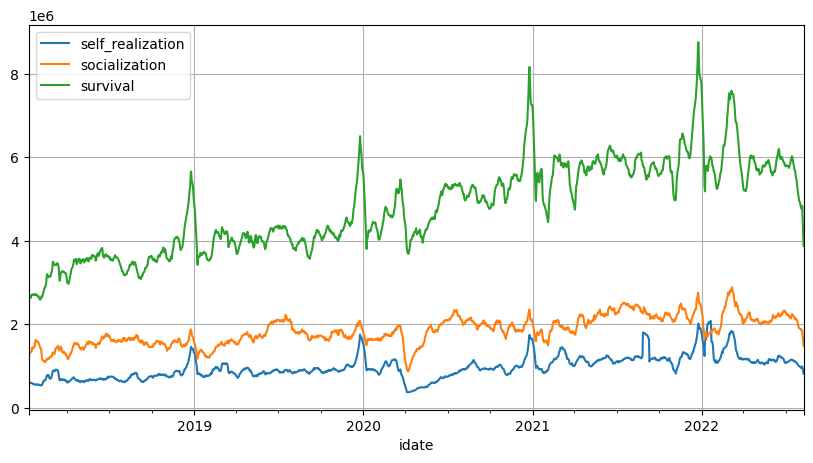

In [2]:
sssr=pd.read_csv('sssr.csv', parse_dates=['idate']).set_index('idate').drop('money', axis=1)
sssr=sssr.rolling(14, center=True).mean().dropna()
sssr.plot(figsize=(10,5), grid=True)
cats=sssr.columns

Линейный тренд, обусловленный инфляцией, удаляем

<Axes: xlabel='idate'>

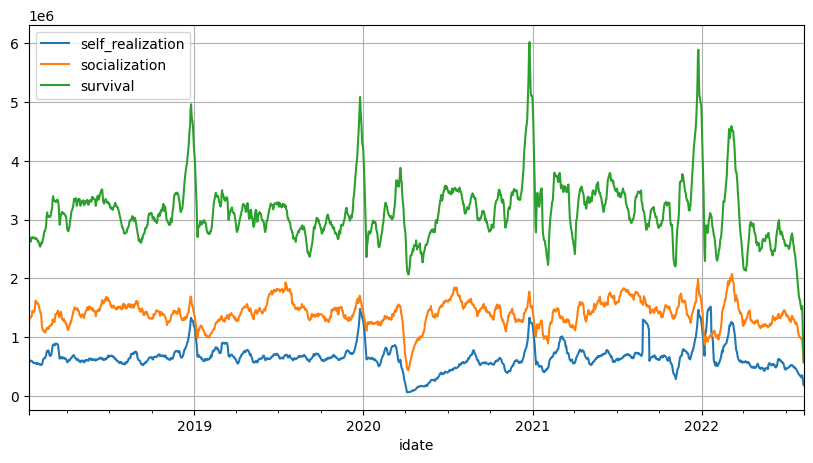

In [3]:
'''Наименьшие квадраты для одной переменной'''
def MLS(x,y):
    x=np.array(x).astype(float)
    y=np.array(y).astype(float) 
    n=len(x)
    sumx, sumy=sum(x), sum(y)
    sumx2=sum([t*t for t in x])
    sumxy=sum([t*u for t,u in zip(x,y)])
    a = (n * sumxy - (sumx * sumy)) / (n * sumx2 - sumx * sumx);
    b = (sumy - a * sumx) / n;
    return a, b
x=np.arange(len(sssr))
for i in cats:
    a,b=MLS(x, sssr[i])
    sssr[i]-=a*x
sssr.plot(figsize=(10,5), grid=True)

В долях от общей суммы по категориям 

self_realization_share    0.123223
socialization_share       0.271309
survival_share            0.605468
dtype: float64

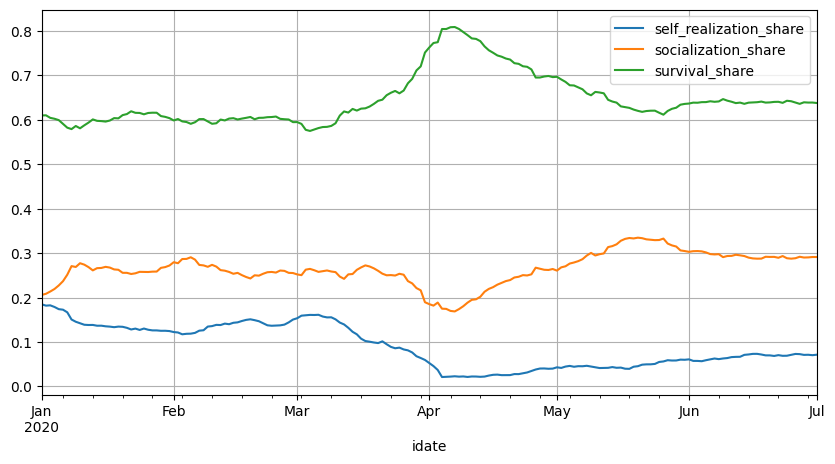

In [4]:
rel=pd.DataFrame(index=sssr.index)
for i in sssr.columns:
    rel[i+'_share']=sssr[i]/sssr.sum(axis=1)
rel['2020-01-01':'2020-07-01'].plot(figsize=(10,5), grid=True)
rel.mean()

Разности первого и второго порядка для определения коэффициентов A и B уравнения d2x+Adx+Bx=0

In [5]:
for i in sssr.columns:
    sssr['d2'+i]=sssr[i].diff(2)
    sssr['d'+i]=sssr[i].diff(1)
sssr.dropna(inplace=True)

#['2019-01-01':'2020-12-31']
x=sssr[cats].values
dx=sssr['d'+cats].values
d2x=sssr['d2'+cats].values
d2x

array([[  17284.4492305 ,  169581.62505236,   63493.3541618 ],
       [ -10022.15934093,   68229.6579095 ,  -41532.32369534],
       [ -20656.57219807,    5658.09505236,  -44218.86726677],
       ...,
       [ -28268.04148379, -122800.30780478, -251535.98440963],
       [-106547.28505522, -230440.39851907, -650135.78655248],
       [-125243.9607695 , -256508.92137621, -652171.71655248]])

In [6]:
from scipy.optimize import minimize
def loss(y):
    A=y[:9].reshape(3,3)
    B=y[9:].reshape(3,3)
    C=-np.array([A.dot(dx[i])+B.dot(x[i]) for i in range(d2x.shape[0])])
    #loss=np.sum(np.abs(d2x-C))
    loss=np.sum(np.linalg.norm(d2x-C))
    return loss
#x0=np.ones(18)
x0=np.random.rand(18)
optim=minimize(loss, x0)#, method='Nelder-Mead')
optim.x

array([-1.19938569, -0.00206116, -0.1261454 , -0.00166284, -1.07358761,
       -0.16972661, -0.11316042, -0.010117  , -1.62186149, -0.01899581,
        0.00458405,  0.00174648,  0.00286374, -0.0100248 ,  0.00376877,
        0.01372547,  0.01620008, -0.01045989])

<Axes: >

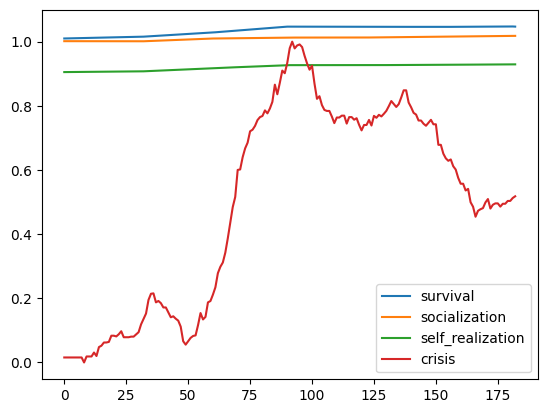

In [7]:
'''Данные об окружающей среде '''
env=pd.read_csv('environment.csv')
env.drop(env[env.date<'2019-11-01'].index, inplace=True)
env.drop(env[env.date>'2020-07-01'].index, inplace=True)
env.plot()

In [8]:
'''Матрицы коэффициентов '''
A=optim.x[:9].reshape(3,3)
B=optim.x[9:].reshape(3,3)
A,B

(array([[-3.24368972, -0.03244578, -0.39862896],
        [ 0.03552788, -3.02522476, -0.51174003],
        [-0.05594576, -0.07342875, -4.72923412]]),
 array([[-0.10598243, -0.00624793,  0.02582032],
        [ 0.00914468, -0.02811485,  0.00998733],
        [ 0.06934624,  0.06285353, -0.04342856]]))

Разностная схема 

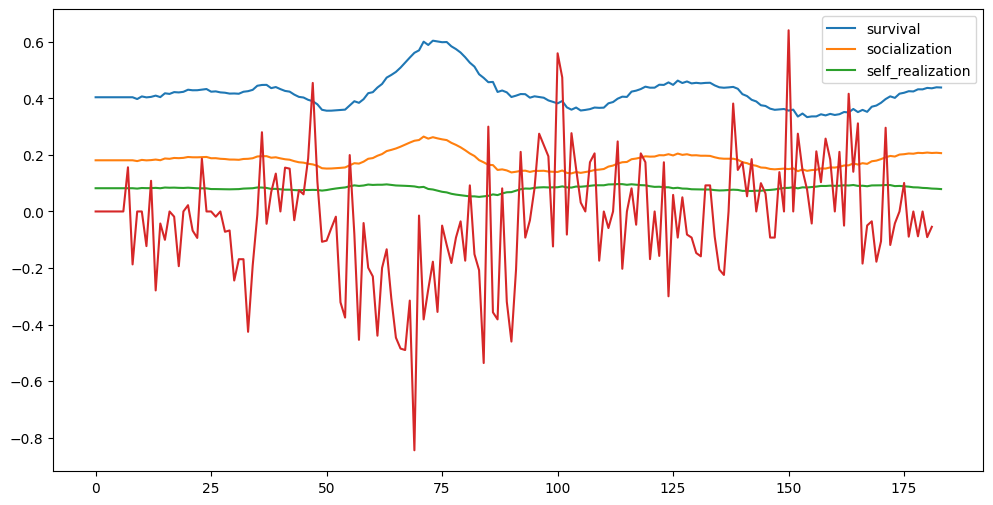

In [9]:
gt=-env.crisis.diff().dropna().values
ft=rel.mean().values[::-1]
#xr=np.array([rel.mean().values,rel.mean().values])*10

step=lambda x1,x2: np.array([((A+np.diag(np.full(3,2))).dot(x1)-x2)]).dot(np.linalg.inv(B+A+np.diag(np.full(3,1))))+gt[i]

xr=np.array([[0,0,0],[0,0,0]])
plt.figure(figsize=(12,6))
for i in range(len(gt)):
    xr=np.concatenate([xr, step(xr[-1], xr[-2])])
    #print(step(xr[-1], xr[-2]))
xr+=1
xr*=ft #масштаб
plt.plot(xr[:])
plt.plot(gt[:len(xr)]*10)
plt.legend(cats[::-1])
plt.show()

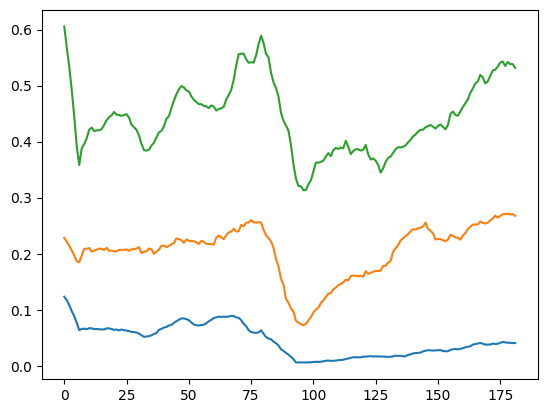

In [10]:
'''Реальные данные для сопоставления'''
res=pd.DataFrame(index=pd.to_datetime(env.date[1:]), columns=np.concatenate([cats+'-model', cats+'-real']))
real=sssr[pd.to_datetime(res.index.min()):pd.to_datetime(res.index.max())][cats].values
real/=real.max(axis=0)
real*=ft[::-1]
plt.plot(real)
plt.show()

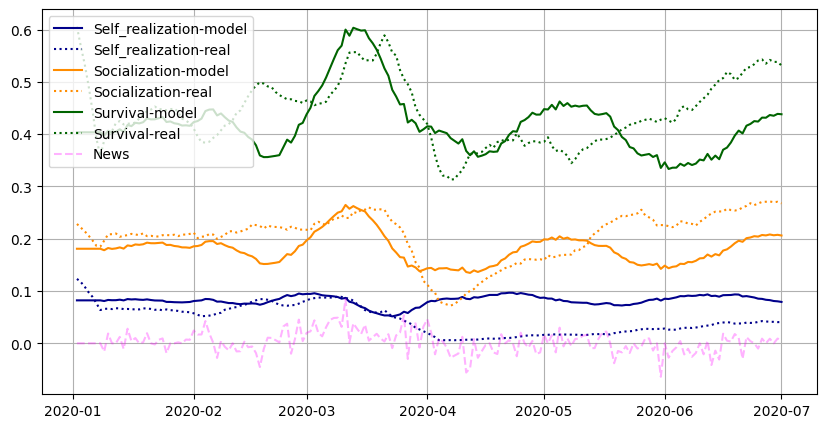

In [11]:
col=['darkblue','darkorange','darkgreen']
res[cats[::-1]+'-model']=xr[2:]
res[cats+'-real']=real
res['news']=gt
plt.figure(figsize=(10,5))
for i,j in enumerate(cats):
    plt.plot(res[j+'-model'], c=col[i], label=j.capitalize()+'-model')
    plt.plot(res[j+'-real'], c=col[i], ls=':', label=j.capitalize()+'-real')
plt.plot(-res.news, c='magenta', alpha=.3, ls='--', label='News' )
plt.legend(loc=2)
plt.grid()
plt.show()

<Axes: xlabel='date'>

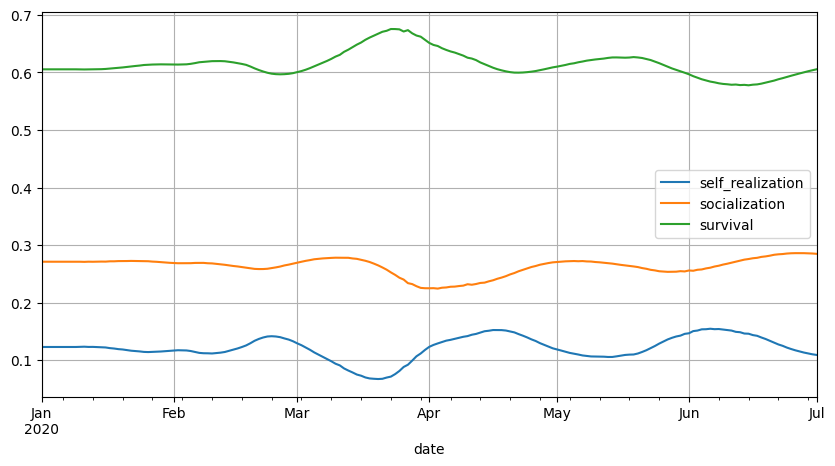

In [14]:
'''В долях общей суммы'''
rpic=pd.DataFrame(index=pd.to_datetime(env.date[:]), columns=cats)
rpic[cats[::-1]]=(np.array([xr[1:, i]/xr[1:].sum(axis=1) for i in range(3)]).T)[:, :183]
rpic.plot(figsize=(10,5), grid=True)